# Goal !

We want to predict the **next Mbappé!**

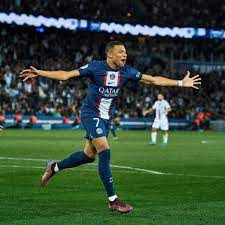

## 00. Coding Best Practices

In [ ]:
# Basic Libraries
import pandas as pd
pd.set_option('display.max_columns', None) 
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Encoding
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

In [ ]:
# Basic functions:
def data_exp(): # first exploration
    print("The dataframe shape is", data.shape, ".")
    print(" ")
    print("The dataframe columns are:")
    print(data.columns)
    print(" ")
    print("The dataframe data types are:")
    print(data.dtypes)
    return data.sample(5)

def data_clean(): # to standarize column names
    data.columns = cc = [column.lower().replace(' ', '_') for column in data] # standarizing the columns
    data.sample(0)
    
# Specific functions for this dataset:
def convert_value(value): # function to convert value to unified format for our target ['Value']
    if isinstance(value, float):
        return value
    elif value.endswith('K'):
        return float(value[1:-1]) * 1000
    elif value.endswith('M'):
        return float(value[1:-1]) * 1000000
    else:
        try:
            return float(value)
        except ValueError:
            return None

## 01 - Getting the Data

In [ ]:
data = pd.read_csv('fifa21_male2.csv')
data_exp()

This dataset contains **one-year** 17.125 player information from 107 different columns.

Our **goal** is to predict who will be **the next Mbappé**, so after reading the dataset [Documentation](https://www.kaggle.com/datasets/ekrembayar/fifa-21-complete-player-dataset?select=fifa21_male2.csv) we decide to proceed with the following **strategy**:

We will select all column 

    *  `We will create a new dataframe to work-with for that.`

* From all numericals related to the player potential, we will get rid of some columns like:
    * `['attacking', 'crossing', 'finishing', 'heading_accuracy','short_passing']` (see code bellow) 
    * Because, for example..
        
       *`"attacking"` = sum ("crossing","finishing","heading_accuracy","short_passing","volleys")
       `"skill"` = sum("dribbling","curve","fk_accuracy","long_passing","ball_control")
       `"base_stats"` = sum ("pac","sho","pas","dri","def","phy")`

* Since the idea is to find some promising talents through `EDA` to predict their future `Score`!
    * The target for our dataset will be `OVA` (overall score) of a player.

* `Value`, `Wage`, and `Release Clause` are interesting columns to work-with.
    * But they contain symbols like € and K so they have to be converted to numericals.
* We will also use features such as `height`, `weight`, etc., 
    * We will convert them to the metrical system and get rid of any quotation symbol or lbs.

## 02 - Cleaning the Data

In [ ]:
data_clean() # to standarize the column names
data = data.rename(columns={"team_&_contract": "team&contract"})

In [ ]:
data.sample(0) # let's check how it looks

In [ ]:
data_copy = data.copy() # as best practices, now we make a safe copy of our data

In [ ]:
# Check if "id" has duplicated values to dealwith
print("There are duplicate values in 'id'.") if data_copy['id'].duplicated().any() else print("All values in 'id' are unique.")

In [ ]:
data_copy = data_copy.set_index('id') # id is unique, so we passed it as the index
data_copy.sample(0)

### Dealing with Null values

In [ ]:
# Check for empty cells in the entire DataFrame
null_cols = data_copy.isnull().sum()
null_cols = null_cols[null_cols > 0]
null_cols

In [ ]:
# We get rid of loan_date since it has way too many NaN values
data_copy = data_copy.drop(columns=["loan_date_end"])

In [ ]:
# We will also remove 423 rows from value. 423 rows =  2,61 % from the total dataset, and It'll improve the model.
data_copy = data_copy.dropna(subset=['value'])
data_copy.shape

In [ ]:
# Now, we check the data from columns like value, wage, and rel_clause
data_copy['value'].head(3)

In [ ]:
data_copy['wage'].head(3)

In [ ]:
data_copy['release_clause'].head(3)

There are many symbols `M`, `K`, `€` located at index[0] and [-1] so we will use an specific function (`convert_value`) to get rid of the symbols, and to properly convert the values to numericals for each case.

In [ ]:
data_copy['value'] = data_copy['value'].apply(convert_value) # Applying the function
data_copy['value'].head(3)

In [ ]:
data_copy['wage'] = data_copy['wage'].apply(convert_value)
data_copy['wage'].head(3)

In [ ]:
data_copy['rel_clause'] = data_copy['release_clause'].apply(convert_value)
data_copy['rel_clause'].head(3)

At this point we realised we created some `NaN` during this processs from previous `€0`.
With futher exploration, we finally got rid of this column.

In [ ]:
data_copy.shape

* After a first data-cleansing we moved from 107 features to 100.
* We can still reduce that number, since we don't want to use categoricals.
* Some columns considered as **categoricals** are actually **numericals**, e.g: `height`, `weight`, etc.
* We will proceed to encode them:

### Encoding

In [ ]:
# Convert height data from feet and inches to centimeters
data_copy['h_cm'] = data_copy['height'].apply(lambda x: int(x.split("'")[0])*30.48 + int(x.split("'")[1].replace('"', ''))*2.54)
data_copy['h_cm'].sample(3)

In [ ]:
# Convert weight data from pounds to kilograms
data_copy['w_kg'] = data_copy['weight'].apply(lambda x: int(x[:-3]) / 2.2046)
data_copy['w_kg'].sample(3)

# ! 
### TO-DO: Adding information regarding w/f, s/m and ir columns, to explain the following changes:

In [ ]:
# Apply lambda function to 'w/f' column
data_copy['w/f_ecd'] = data_copy['w/f'].apply(lambda x: int(x[0]))
data_copy['w/f_ecd'].sample(3)

In [ ]:
# Apply lambda function to 's/f' column
data_copy['sm_ecd'] = data_copy['sm'].apply(lambda x: int(x[0]))
data_copy['sm_ecd'].sample(3)

In [ ]:
# Apply lambda function to 'w/f' column
data_copy['ir_ecd'] = data_copy['ir'].apply(lambda x: int(x[0]))
data_copy['ir_ecd'].sample(3)

# ! 
### TO-DO: Defining a function for the lambda above, to make it easier to run (if there is some time left...)
#### e.g> def lambda_game():

### Further Encoding

In [ ]:
# Initialize the LabelEncoder object
le = LabelEncoder()

# Fit and transform the data frame column
data_copy['a/w_ecd'] = le.fit_transform(data_copy['a/w'])
data_copy['d/w_ecd'] = le.fit_transform(data_copy['d/w'])

In [ ]:
# Modify cells with 'K' character, leave others unchanged, turn it to integer
data_copy['hits'] = data_copy['hits'].apply(lambda x: float(x.replace('K','')) * 1000 if isinstance(x, str) and 'K' in x else x).astype(int)

In [ ]:
# Create a new dataframe with only the numerical columns using select_dtypes
X_N = data_copy.select_dtypes(np.number).apply(lambda x: round(x,2)).fillna(0) # we also deal with NaN values
X_N.head()

In [ ]:
data_headers = list(X_N.columns.values) # to get and check all column names
print("The Column Headers are :", data_headers) 

In [ ]:
# We simply move our target Value to the right, for readibility
X_N = X_N[['age', 'ova', 'bov', 'pot', 'growth', 'wage', 'attacking', 'crossing', 'finishing', 'heading_accuracy',
           'short_passing', 'volleys', 'skill', 'dribbling', 'curve', 'fk_accuracy', 'long_passing', 'ball_control', 'movement',
           'acceleration', 'sprint_speed', 'agility', 'reactions', 'balance', 'power', 'shot_power', 'jumping', 'stamina',
           'strength', 'long_shots', 'mentality', 'aggression', 'interceptions', 'positioning', 'vision', 'penalties',
           'composure', 'defending', 'marking', 'standing_tackle', 'sliding_tackle', 'goalkeeping', 'gk_diving', 'gk_handling',
           'gk_kicking', 'gk_positioning', 'gk_reflexes', 'total_stats', 'base_stats', 'pac', 'sho', 'pas', 'dri', 'def', 'phy',
           'hits', 'rel_clause', 'h_cm', 'w_kg', 'w/f_ecd', 'sm_ecd', 'ir_ecd', 'a/w_ecd', 'd/w_ecd', 'value']]
X_N.shape

* To make it simple to work with our model, we will get rid of the following columns:
    * ['attacking', 'crossing', 'finishing', 'heading_accuracy','short_passing', 'volleys', 'skill', 'dribbling', 'curve', 'fk_accuracy', 'long_passing', 'ball_control', 'movement','acceleration', 'sprint_speed', 'agility', 'reactions', 'balance', 'power', 'shot_power', 'jumping', 'stamina','strength', 'long_shots', 'mentality', 'aggression', 'interceptions', 'positioning', 'vision', 'penalties','composure', 'defending', 'marking', 'standing_tackle', 'sliding_tackle', 'goalkeeping', 'gk_diving', 'gk_handling', 'gk_kicking', 'gk_positioning', 'gk_reflexes'] 
* Since it is already summerized in `total_stats`

In [ ]:
X_N = X_N[['age', 'ova', 'bov', 'pot', 'wage', 'goalkeeping', 'total_stats', 'base_stats', 'pac', 'sho', 'pas', 
                  'dri', 'def', 'phy', 'hits', 'h_cm', 'w_kg', 'w/f_ecd', 'sm_ecd', 'ir_ecd', 'a/w_ecd', 'd/w_ecd', 'value']]
X_N.shape

* We got a cleaned dataset with `17.125` numerical player information in `23` distinct columns.

In [ ]:
X_N.sample(3)

## 03 - Exploratory Data Analysis

In [ ]:
X_N.describe() # basic statistics for all numerical values

In [ ]:
# Looking at promising talents
data_copy['pot_minus_ova'] = data_copy['pot'] - data_copy['ova'] 

# Create a new DataFrame that contains only the rows with "difference" > 10 and age < 21
talents = data_copy[(data_copy['pot_minus_ova'] > 10) & (data_copy['age'] < 21)]
talents.head(3)

In [ ]:
# Group the data by country and count the number of players in each country
talents_by_country = talents.groupby('nationality')['name'].count().sort_values(ascending=False)

# Plot a bar chart of the top 10 countries with the most players
talents_by_country.head(10).plot(kind='bar')

# Add labels and a title to the chart
plt.xlabel('Country')
plt.ylabel('Number of players')
plt.title('Top 10 countries with the most promising talents')

# Display the chart
plt.show()

In [ ]:
# Looking at MVPs with rating >80
mvps = data_copy[(data_copy['ova'] > 80)]

# Group the data by country and count the number of players in each country
mvps_by_country = mvps.groupby('nationality')['name'].count().sort_values(ascending=False)

# Plot a bar chart of the top 10 countries with the most players
mvps_by_country.head(10).plot(kind='bar')

# Add labels and a title to the chart
plt.xlabel('Country')
plt.ylabel('Number of players')
plt.title('Top 10 countries with the most valuable players')

# Display the chart
plt.show()

## 04 - Processing Data

### Check correlations

In [ ]:
# Correlation Matrix
X_N_corr = round(X_N.corr(),2)
X_N_corr

In [ ]:
# Correlation Matrix-Heatmap Plot
mask = np.zeros_like(X_N_corr)
mask[np.triu_indices_from(mask)] = True # optional, to hide repeat half of the matrix
f, ax = plt.subplots(figsize=(15, 15))
ax = sns.heatmap(X_N_corr, mask=mask, annot=True, linewidths=.5, ax=ax)
plt.show()

In [ ]:
# After checking the features and target value and the correlation within the values we decide to remove: bov
X_N = X_N.drop(columns=["bov"])
X_N.sample(2)

In [ ]:
# We will also drop 'pas', it shares multicollinearity with 'dri' and it's to closer to 1.
X_N = X_N.drop(columns=["pas"])
X_N.sample(2)

### Normalizing the Data

In [ ]:
transformer = MinMaxScaler().fit(X_N) # rescale the Data into 0,1 for our model
X_N_minmax = transformer.transform(X_N) 

In [ ]:
# create new data frame using data from 'X_N_minmax'
X_N_normalized = pd.DataFrame(X_N_minmax, columns = X_N.columns)
X_N_normalized.sample(5) 

Красивый!
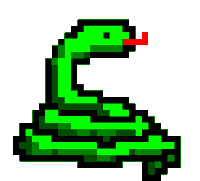

In [ ]:
for i in X_N_normalized:
    sns.distplot(X_N_normalized[i])
    plt.show()

# ! 
### TO-DO: Making better plots and heatmaps... Also, what do we do with 'Hits'?


## 05 - Modeling

### X-Y Split

In [ ]:
Y = X_N_normalized['value']
X = X_N_normalized.drop(['value'], axis=1) 
X.sample(5)

### Train-Test Split

In [ ]:
# We define train and test for X and Y
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42) 
# test_size = We give 30% for testing and 70% for testing
# random_state = it'll improve the model to divide always the model in the same way

In [ ]:
len(X)*0.7 # Len before the test

In [ ]:
len(X_test) # Len after the test

In [ ]:
model = LinearRegression() # We have the model
model.fit(X_train,y_train) # We fit the training data into the model

## 06 - Model Validation

In [ ]:
predictions = model.predict(X_test)

In [ ]:
r2_score(y_test, predictions), mean_squared_error(y_test, predictions, squared=False), mean_squared_error(y_test, predictions)

In [ ]:
r2 = r2_score(y_test, predictions)
RMSE = mean_squared_error(y_test, predictions, squared=False)
MSE = mean_squared_error(y_test, predictions)
MAE = mean_absolute_error(y_test, predictions)
print("R2 = ", r2)
print("RMSE = ", RMSE)
print("The value of the metric MSE is ", MSE)
print("MAE = ", MAE)